In [3]:
import pandas as pd
import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt
%matplotlib inline
from math import ceil

In [4]:
def top_basket (K, *basket): # K - filtration coefficient for p-value. *basket - the collection of Pandas DataFrames. 
    """
        This function creates a table and calculates all possible options for building a basket from the transferred trading 
    instruments using a multiple regression model.
        According to the scheme:
        1 dependent trading instrument versus 1 independent trading instrument: Y - k1 * X1
        1 dependent trading instrument versus 2 independent trading instruments: Y - k1 * X1 - k2 * X2
        1 dependent trading instrument versus 3 independent trading instruments: Y - k1 * X1 - k2 * X2 - k3 * X3
        The function returns baskets (in the form of graphs with coefficients) filtered using the Dickey-Fuller test,
    where p-value is less than or equal to the specified value K.
    """
    x = len(basket)
    x1 = x - 1
    x2 = ((x-2)**2 + (x-2)) / 2
    s = x-3
    x3 = 0
    while s > 0:
        x3 = x3 + ((s**2 + s) / 2)
        s = s - 1
        
    P_table = [[0] * int(x1+x2+x3+1) for i in range(x)] # creating an empty table for p-value
    C_table = [[0] * int(x1+x2+x3+1) for i in range(x)] # creating an empty table for coefficients
    N_table = [[0] * int(x1+x2+x3+1) for i in range(x)] # creating an empty table for names of baskets
    Chart_table = [[0] * int(x1+x2+x3+1) for i in range(x)] # creating an empty table for data for charts    
    
    for i in range(len(basket)):
        P_table[i][0] = list(basket[i].keys())[0]
        C_table[i][0] = list(basket[i].keys())[0]
        N_table[i][0] = list(basket[i].keys())[0]
        Chart_table[i][0] = list(basket[i].keys())[0]        
    
    main_basket_name = []
    for i in range(len(basket)):
        main_basket_name.append(list(basket[i].keys())[0])
    
    main_basket_list = []
    for i in range(len(basket)):
        main_basket_list.append(list(basket[i].values())[0])
        
        
    
    """***************************GET_BASKET_START*************************************************"""
    def get_basket(*basket): # *basket - the collection of Pandas DataFrames
        """
        This function aligns data with dates and daily close prices for transmitted trading instruments.
        Finds the regression coefficients (dependent variable is the first variable in the * basket collection, other variables
        in the collection are independent) using a multiple regression model. Builds a basket, that is, difference:
        Y - k1 * X1 - k2 * X2 - ... - kn * Xn. The resulting time series is checked for stationarity by the Dickey-Fuller test. 
        Function returns: p-value, regression coefficients, received basket data (time series).
        """
        # Returns p-value, regression coefficients, received spread / basket data (time series)
        
        # Frames start date --------------------------------------------------------------------------
        start_date = basket[0]['Date'][0]
        for df in basket:
            if df['Date'][0] > start_date:
                start_date = df['Date'][0]          
            
        # Frames end date ----------------------------------------------------------------------------
        end_date = basket[0]['Date'][len(basket[0]['Date'])-1]
        for df in basket:
            if df['Date'][len(df['Date'])-1] < end_date:
                end_date = df['Date'][len(df['Date'])-1]           
    
        # Date alignment of all frames----------------------------------------------------------------  
        newDF = pd.date_range(start = start_date, end = end_date)
        maska = pd.DataFrame(data = newDF, columns = ['Date'])
        date = maska['Date'].tolist()

        basket_date = [0] * len(basket)
        basket_close = [0] * len(basket)
        for i in range(len(basket)):
            basket_date[i] = basket[i]['Date'].tolist()
            basket_close[i] = basket[i]['Close'].tolist()
    
        basket_d_c = basket_date + basket_close
        basket_list = [[0] * len(date) for i in range(len(basket_d_c))]    
        for i in range(len(basket)):
            for j in range(len(date)):
                if date[j] in basket_d_c[i]:
                    basket_list[i][j] = date[j]
                    basket_list[i+len(basket)][j] = basket_d_c[i+len(basket)][basket_d_c[i].index(date[j])]
                else:
                    basket_list[i][j] = np.nan
                    basket_list[i+len(basket)][j] = np.nan
    
        columns = [0] * len(basket_list)
        for i in range(len(basket)):
            columns[i] = 'Date_' + str(i)
            columns[i+len(basket)] = 'Close_' + str(i)    
    
        basket_frame = pd.DataFrame()
        for i in range(len(basket_list)):
            basket_frame[str(i)] = basket_list[i]    
    
        basket_frame.columns = columns
        basket_frame.dropna(inplace = True)
        basket_frame.reset_index(drop=True, inplace = True)
        basket_frame.drop(basket_frame.columns[[i for i in range(len(basket))]], axis = 1, inplace = True)
    
        # Get basket---------------------------------------------------------------------------------
        regr = linear_model.LinearRegression()
        x = basket_frame.iloc[range(len(basket_frame)), [i for i in range(1, len(basket))]]
        y = basket_frame.iloc[range(len(basket_frame)), 0]
        regr.fit(x, y)        
    
        basket_frame['Basket'] = basket_frame['Close_0'] - regr.coef_[0] * basket_frame['Close_1']
        if len(basket) > 2:
            for i in range(2, len(basket)):
                basket_frame['Basket'] = basket_frame['Basket'] - regr.coef_[i-1] * basket_frame['Close_' + str(i)]            
    
        # Dickey-Fuller test-------------------------------------------------------------------------
        from statsmodels.tsa.stattools import adfuller
        X = basket_frame['Basket']
        result = adfuller(X)    
        
        return [result[1], regr.coef_, X]
    """*****************************GET_BASKET_END************************************************"""
    
    
    i = 0
    while i < len(main_basket_list):
        main_basket_list[i].drop(['Time', 'Open', 'High', 'Low', 'Volume'], axis = 1, inplace = True)        
        main_basket_list[i]['Date'] = pd.to_datetime(main_basket_list[i]['Date'])
        i = i + 1
    
    # Frames start date alignment--------------------------------------------------------------------
    start_date = main_basket_list[0]['Date'][0]
    for df in main_basket_list:
        if df['Date'][0] > start_date:
            start_date = df['Date'][0]
    print(start_date)       
           
    for df in main_basket_list:
        if df['Date'][0] != start_date:
            index = df.loc[df['Date'] == start_date].index[0]
            df.drop(df.index[range(index)], inplace = True)
            df.reset_index(drop=True, inplace = True)
            
    # Frames end date alignment----------------------------------------------------------------------
    end_date = main_basket_list[0]['Date'][len(main_basket_list[0]['Date'])-1]
    for df in main_basket_list:
        if df['Date'][len(df['Date'])-1] < end_date:
            end_date = df['Date'][len(df['Date'])-1]
    print(end_date)         
        
    for df in main_basket_list:
        if df['Date'][len(df['Date'])-1] != end_date:
            index = df.loc[df['Date'] == end_date].index[0]
            df.drop(df.index[range(index+1, len(df['Date']))], inplace = True)
            df.reset_index(drop=True, inplace = True)
    
    #--------------------------------1:1------------------------------------------------------------
    for i in range(len(main_basket_list)):
        o = main_basket_list.pop(i)
        for j in range(1, x1+1):
            V = get_basket(o, main_basket_list[j-1])
            P_table[i][j] = round(V[0], 4)
            C_table[i][j] = V[1]
            Chart_table[i][j] = V[2]
        main_basket_list.insert(i, o)
    
    for i in range(len(main_basket_name)):
        o = main_basket_name.pop(i)
        for j in range(1, x1+1):
            N_table[i][j] = o + '-' + main_basket_name[j-1]
        main_basket_name.insert(i, o)
    
    #--------------------------------1:2-----------------------------------------------------------
    new_list_p = []
    new_list_c = []
    new_list_n = []
    new_list_chart = []
    for y in range(len(main_basket_list)):
        o = main_basket_list.pop(y)
        for i in range(len(main_basket_list)):
            for j in range(i+1, len(main_basket_list)):
                V = get_basket(o, main_basket_list[i], main_basket_list[j])
                new_list_p.append(V[0])
                new_list_c.append(V[1])
                new_list_chart.append(V[2])
        main_basket_list.insert(y, o)
    
    for y in range(len(main_basket_name)):
        o = main_basket_name.pop(y)
        for i in range(len(main_basket_name)):
            for j in range(i+1, len(main_basket_name)):
                new_list_n.append(o + '-' + main_basket_name[i] + '-' + main_basket_name[j])                
        main_basket_name.insert(y, o)
    
    z = 0
    for i in range(len(main_basket_list)):
        for j in range(int(x1+1), int(x1+x2+1)):
            P_table[i][j] = round(new_list_p[z], 4)
            C_table[i][j] = new_list_c[z]
            N_table[i][j] = new_list_n[z]
            Chart_table[i][j] = new_list_chart[z]
            z = z + 1
   
    #--------------------------------1:3-----------------------------------------------------------
    prom_list = []
    for y in range(len(main_basket_list)):
        o = main_basket_list.pop(y)
        for i in range(len(main_basket_list)):
            for j in range(i+1, len(main_basket_list)):
                z =[main_basket_list[i]] + [main_basket_list[j]]
                prom_list.append(z)        
        main_basket_list.insert(y, o)
    
    new_list_3_p = []
    new_list_3_c = []
    new_list_3_chart = []
    limit = x2
    start = 0
    for b in range(len(main_basket_list)):
        o = main_basket_list.pop(b)
        i = 0
        x = len(basket)
        while i <= (len(main_basket_list)-2):
            for j in range((int(start) + int((x2 - ((((x-1)-2)**2 + ((x-1)-2)) / 2)))), int(limit)):
                el = get_basket(o, main_basket_list[i], prom_list[j][0], prom_list[j][1])
                new_list_3_p.append(el[0])
                new_list_3_c.append(el[1])
                new_list_3_chart.append(el[2])
            x = x - 1
            i = i + 1    
        limit = limit + x2
        start = start + x2
        main_basket_list.insert(b, o)
    
    prom_list_name = []
    for y in range(len(main_basket_name)):
        o = main_basket_name.pop(y)
        for i in range(len(main_basket_name)):
            for j in range(i+1, len(main_basket_name)):
                z =[main_basket_name[i]] + [main_basket_name[j]]
                prom_list_name.append(z)        
        main_basket_name.insert(y, o)
    
    new_list_3_n = []
    limit = x2
    start = 0
    for b in range(len(main_basket_name)):
        o = main_basket_name.pop(b)
        i = 0
        x = len(basket)
        while i <= (len(main_basket_name)-2):
            for j in range((int(start) + int((x2 - ((((x-1)-2)**2 + ((x-1)-2)) / 2)))), int(limit)):
                new_list_3_n.append(o + '-' + main_basket_name[i] + '-' + prom_list_name[j][0] + '-' + prom_list_name[j][1])                
            x = x - 1
            i = i + 1    
        limit = limit + x2
        start = start + x2
        main_basket_name.insert(b, o)
        
    z = 0
    for i in range(len(main_basket_list)):
        for j in range(int(x1+x2+1), len(P_table[i])):
            P_table[i][j] = round(new_list_3_p[z], 4)
            C_table[i][j] = new_list_3_c[z]
            N_table[i][j] = new_list_3_n[z]
            Chart_table[i][j] = new_list_3_chart[z]
            z = z + 1    
    
    #----------------------------Charts-------------------------------------------------------------
    count = 0
    for i in range(len(P_table)):
        for j in range(1, len(P_table[i])):
            if P_table[i][j] <= K:
                count = count + 1
    
    plot_table = []
    plot_name = []
    plot_coef = []
    for i in range(len(P_table)):
        for j in range(1, len(P_table[i])):
            if P_table[i][j] <= K:
                plot_table.append(Chart_table[i][j])
                plot_name.append(N_table[i][j])
                plot_coef.append(C_table[i][j])
       
    axs = plt.figure(figsize=(14, count+len(basket)+2)).subplots(ceil(count/3), 3)    
    for ax, data, name, coef in zip(axs.flat, plot_table, plot_name, plot_coef):        
        ax.plot(data)
        ax.axhline(y=(np.mean(data) + 2*np.std(data)), color='r', linestyle='--');
        ax.axhline(y=(np.mean(data) - 2*np.std(data)), color='r', linestyle='--');
        ax.set_title(name+': '+str([round(x, 4) for x in coef]))
        
    return 

2011-03-03 00:00:00
2020-06-26 00:00:00


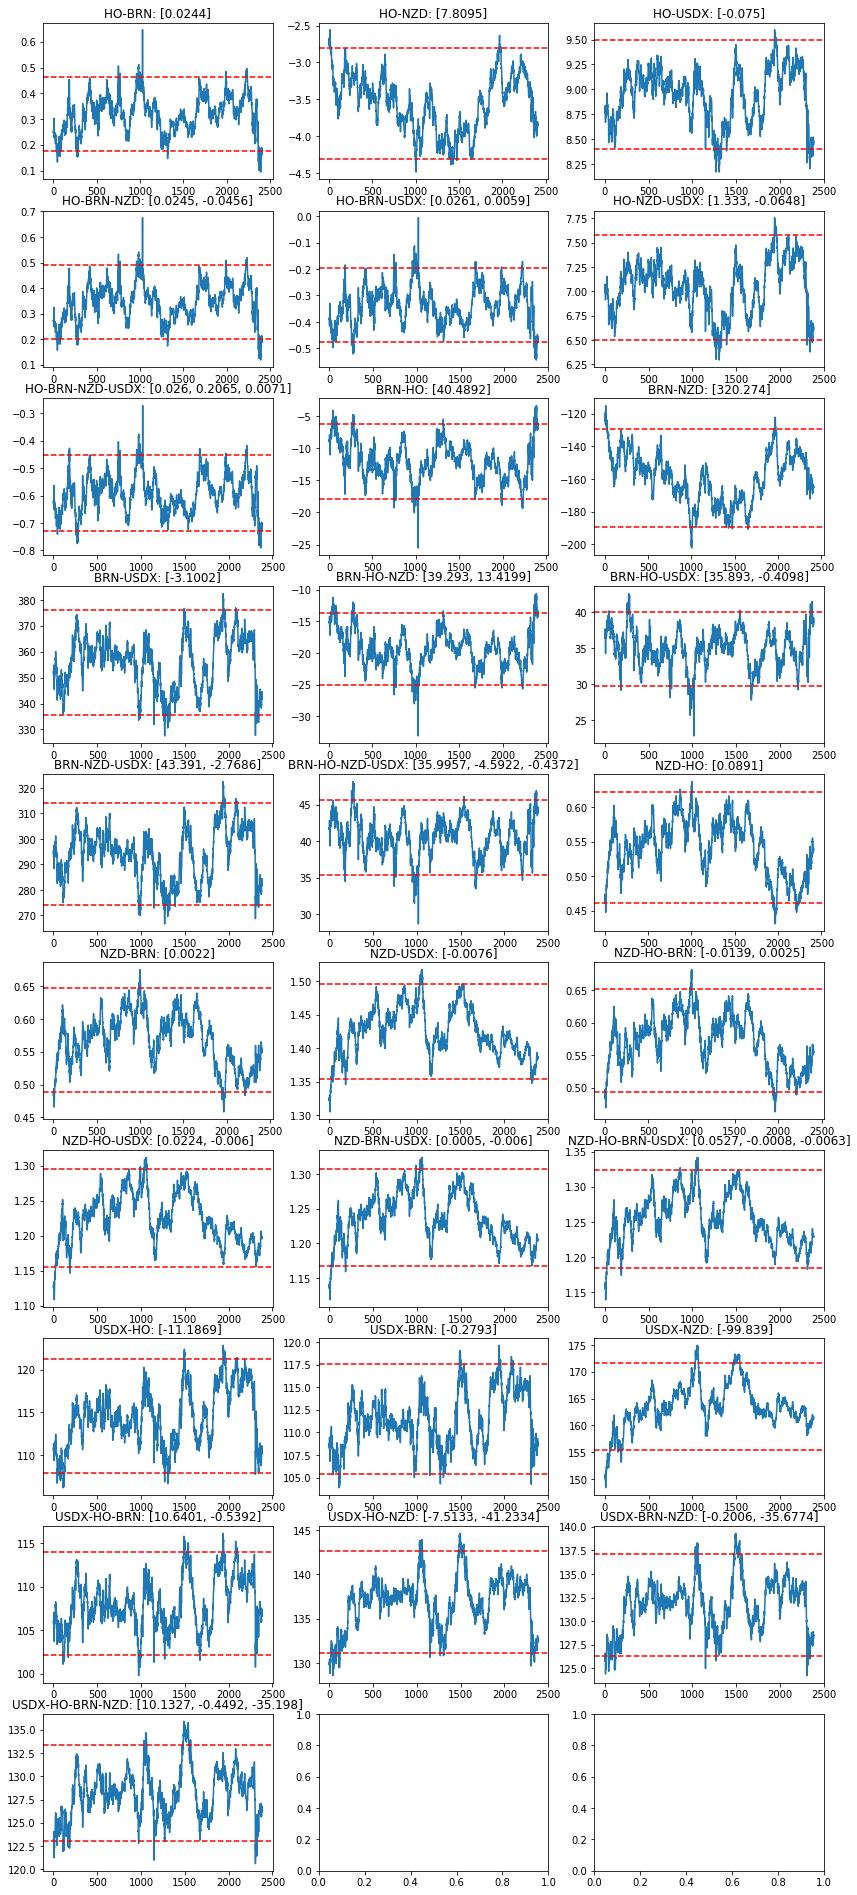

In [5]:
column_names = ['Date', 'Time', 'Open', 'High', 'Low', 'Close', 'Volume']
HO = {'HO': pd.read_csv(r'https://raw.githubusercontent.com/gelono/github-first/master/HO1440.csv', header = None, names = column_names)}
BRN = {'BRN': pd.read_csv(r'https://raw.githubusercontent.com/gelono/github-first/master/BRN1440.csv', header = None, names = column_names)}
ES = {'ES': pd.read_csv(r'https://raw.githubusercontent.com/gelono/github-first/master/ES1440.csv', header = None, names = column_names)}
CL = {'CL': pd.read_csv(r'https://raw.githubusercontent.com/gelono/github-first/master/CL1440.csv', header = None, names = column_names)}
AUD = {'AUD': pd.read_csv(r'https://raw.githubusercontent.com/gelono/github-first/master/AUDUSD1440.csv', header = None, names = column_names)}
GBP = {'GBP': pd.read_csv(r'https://raw.githubusercontent.com/gelono/github-first/master/GBPUSD1440.csv', header = None, names = column_names)}
NQ = {'NQ': pd.read_csv(r'https://raw.githubusercontent.com/gelono/github-first/master/NQ1440.csv', header = None, names = column_names)}
NZD = {'NZD': pd.read_csv(r'https://raw.githubusercontent.com/gelono/github-first/master/NZDUSD1440.csv', header = None, names = column_names)}
CAD = {'CAD': pd.read_csv(r'https://raw.githubusercontent.com/gelono/github-first/master/USDCAD1440.csv', header = None, names = column_names)}
USDX = {'USDX': pd.read_csv(r'https://raw.githubusercontent.com/gelono/github-first/master/USDX1440.csv', header = None, names = column_names)}

top_basket(0.05, HO, BRN, NZD, USDX)